<a href="https://colab.research.google.com/github/naenumtou/ifrs9/blob/main/PD/generatorMatrix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Set auto reload
%reload_ext autoreload
%autoreload 2

In [2]:
# Import libraries
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

# Config
%config InlineBackend.figure_format = 'retina' #Retina display
pd.options.display.float_format = '{:.4f}'.format #Change display format in DataFrame table
warnings.filterwarnings('ignore') #Disable warning
plt.style.use('seaborn-deep') #Plot style

In [3]:
# Define plot matrix function
def plotMatrix(data, plotName, format = None):
  plt.figure(figsize = (10, 6))
  plt.title(f'{plotName}')
  if format is None:
    formatType = '.4f'
    cmapType = 'RdYlGn'
  else:
    formatType = '.2%'
    cmapType = 'RdYlGn_r'
  ax = sns.heatmap(
      data,
      annot = True,
      fmt = formatType,
      xticklabels = True,
      yticklabels = True,
      cmap = cmapType,
      cbar = False
  )
  ax.xaxis.tick_top() # x-axis on top
  ax.xaxis.set_label_position('top')
  return plt.show()

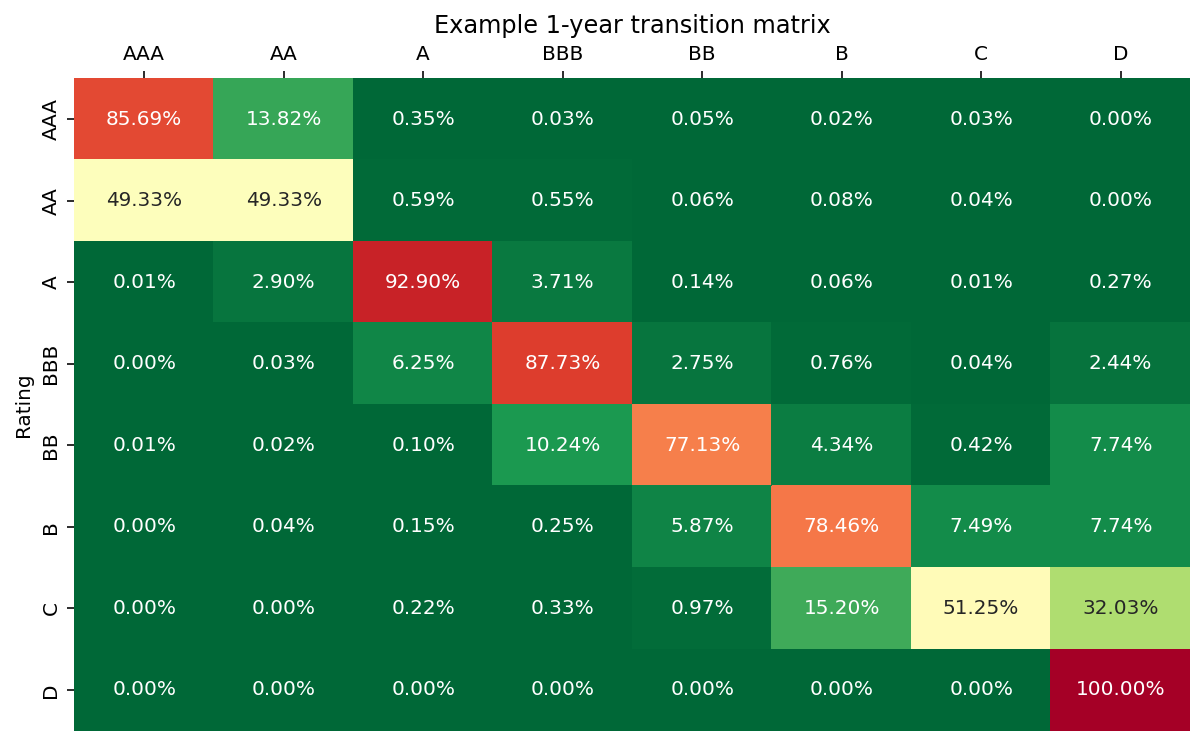

In [4]:
# Import data
matrix = pd.read_csv(
    'https://raw.githubusercontent.com/naenumtou/ifrs9/main/PD/datasets/exampleMatrix.csv'
).set_index('Rating')

# Show matrix
plotMatrix(matrix, 'Example 1-year transition matrix', 'Percent')

### A Generator matrix
Let $P$ be a time-homogeneous Markov transition matrix (Rating migration in this case), an $N × N$ real transition matrix with nonnegative entries (>0) and with row of sums is equal to 1. We are interested in finding a generator $Q$, an $N × N$ real matrix with nonnegative off-diagonal entries and with row-sums 0. The formula below is used to find the generator matrix $Q$, sometimes called Taylor’s expansion:

\begin{align}
        Q = (P - I) - \frac{(P - I)^2}{2} + \frac{(P - I)^3}{3} - \frac{(P - I)^4}{4} + ...
    \end{align}

We can normalise the equation above by using this form:

\begin{align}
        Q = \sum_{n = 1}^N \frac{(-1)^{n + 1}(P - I)^n}{n}
    \end{align}

where;
- $P$ is the transition matrix or rating migration.
- $I$ is the identity matrix by $N × N$.
- $N$ is the size of transition matrix.

In [5]:
# Define generator matrix function
def GeneratorMatrix(P):
  # Define identity matrix
  I = pd.DataFrame(
      np.identity(P.shape[0]),
      index = P.index,
      columns = P.columns
  )
  # Generator matrix
  generatedMatrix = None
  for n in range(1, P.shape[0] + 1):
    expandMatrix = pd.DataFrame(
        np.linalg.matrix_power(
            P - I, n
        ),
        index = P.index,
        columns = P.columns
    )
    expandMatrix = ((-1)**(n + 1)) * (expandMatrix / n)
    if generatedMatrix is None:
      generatedMatrix = expandMatrix.copy()
    else:
      generatedMatrix += expandMatrix
  return generatedMatrix

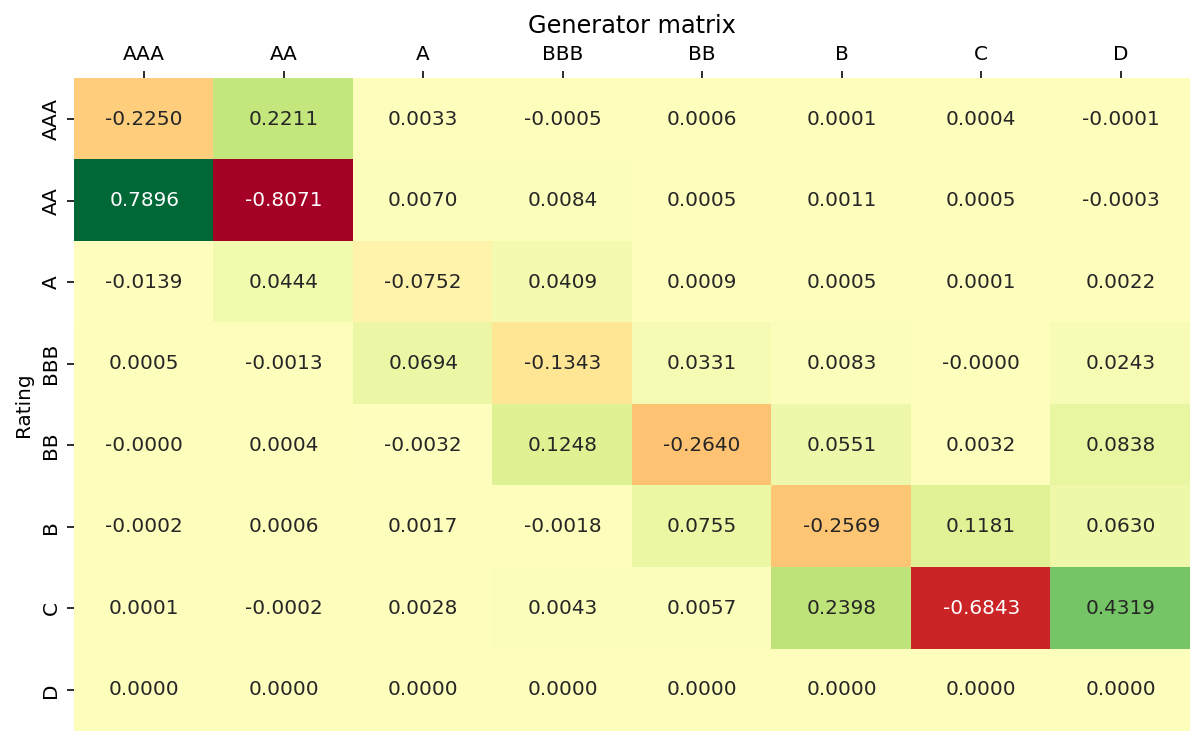

In [6]:
# Generator matrix
generatorMatrix  = GeneratorMatrix(matrix)

# Show matrix
plotMatrix(generatorMatrix, 'Generator matrix')

### A Exact generator
The $Q$ is already obtained. Then, it can be adjusted by adding the negative values back into all the entries of the same row (not just the diagonal one) which have the correct sign, proportional to their absolute values. That is, we could instead let:

\begin{align}
        G_{i} = |q_{ii}| + \sum_{j \neq i}max(q_{ij}, 0)
    \end{align}

and 

\begin{align}
        B_{i} = \sum_{j \neq i}max(-q_{ij}, 0)
    \end{align}

where;
- $i$ is the row postion of generator matrix $Q$.
- $j$ is the column postion of generator matrix $Q$.
- $q$ is the generator value of generator matrix $Q$.

The Exact Generator can be obtained following condition:

\begin{align}
        q_{Exact_{ij}} = \left\{
        \begin{array}{cl}
        0, & i \neq j; q_{ij} < 0 \\
        q_{ij} - B_{i}|q_{ij}|/G_{i}, & G_{i} > 0 \\
        q_{ij}, & G_{i} = 0
        \end{array}
        \right.
    \end{align}

From the conditions above, the $Q_{Exact}$  is obtained.

In [7]:
# Define exact generator function
def ExactGenerator(Q):
  # Define Gi and Bi
  # Gi
  GiMatrix = Q.copy()
  for i in range(Q.shape[1]):
    for j in range(Q.shape[0]):
      if i == j: #Diagonal matrix
        GiMatrix.iloc[i, j] = abs(GiMatrix.iloc[i, j])
      else: #Non-Diagonal matrix
        GiMatrix.iloc[i, j] = max(GiMatrix.iloc[i, j], 0)
  Gi = GiMatrix.sum(axis = 1)
  # Bi
  BiMatrix = Q.copy()
  for i in range(Q.shape[1]):
    for j in range(Q.shape[0]):
      if i == j: #Diagonal matrix
        BiMatrix.iloc[i, j] = 0
      else: #Non-Diagonal matrix
        BiMatrix.iloc[i, j] = max(-BiMatrix.iloc[i, j], 0)
  Bi = BiMatrix.sum(axis = 1)
  # Exact generator
  exactQ = Q.copy()
  for i in range(Q.shape[1]):
    for j in range(Q.shape[0]):
      if i != j and Q.iloc[i, j] < 0: #Non-Diagonal matrix
        exactQ.iloc[i, j] = 0
      else:
        exactQ.iloc[i, j] = Q.iloc[i, j] - ((Bi[i] * abs(Q.iloc[i, j])) / Gi[i])
  return exactQ.fillna(0)

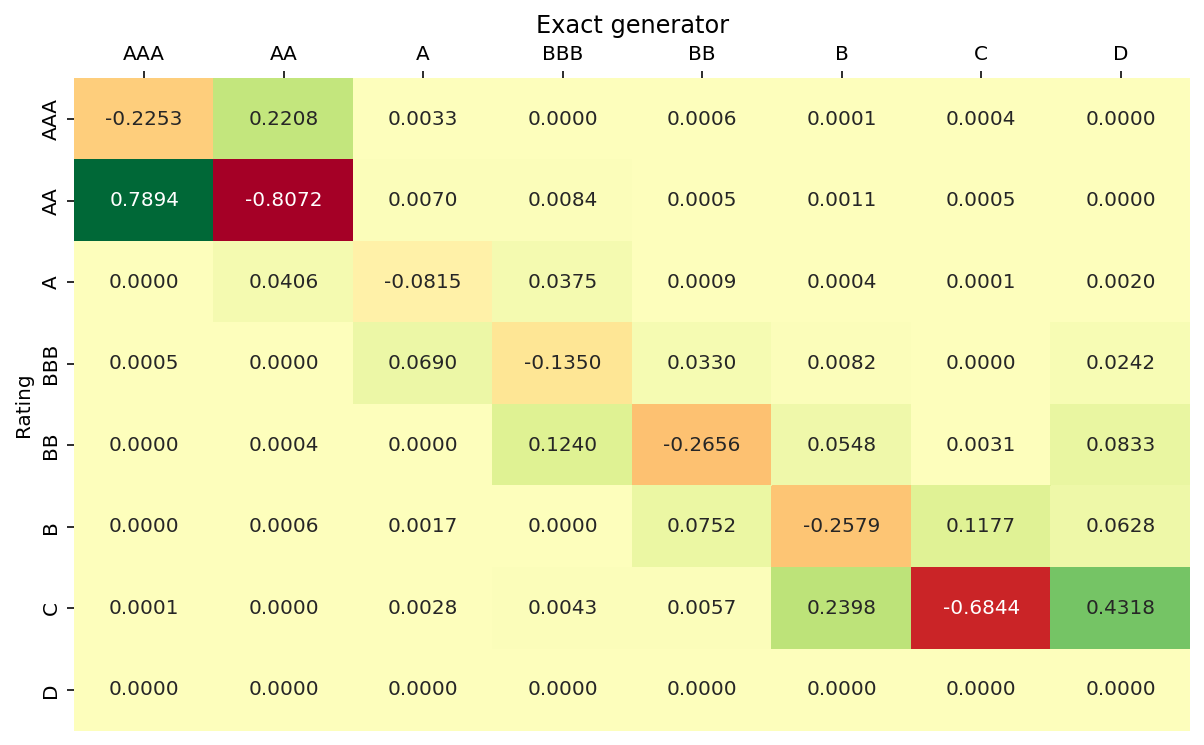

In [8]:
# Exact generator
exactGenerator  = ExactGenerator(generatorMatrix)

# Show matrix
plotMatrix(exactGenerator, 'Exact generator')

### A Exact transition matrix
Once we obtained $Q_{Exac}$, we then need to convert $exp(Q_{Exact})$ the exact generator into transition matrix form $P_{Exact}$. The formula below is being used for such the covert process:

\begin{align}
        exp(tQ_{Exact}) = I + tQ_{Exact} + \frac{(tQ_{Exact})^2}{2!} + \frac{(tQ_{Exact})^3}{3!} + \frac{(tQ_{Exact})^4}{4!} + ...
    \end{align}

where;
- $Q_{Exact}$ is the exact generator.
- $I$ is the identity matrix by $N × N$.
- $t$ is the time horizon for transition matrix e.g. 1 for 1-Year transition rate or 0.5 for half-year transition rate.

In [9]:
# Define exact transition matrix
def ExactMatrix(exactQ):
  # Define identity matrix
  I = pd.DataFrame(
      np.identity(exactQ.shape[0]),
      index = exactQ.index,
      columns = exactQ.columns
  )
  # Exact transition matrix
  exactMatrix = None
  for n in range(1, exactQ.shape[0] + 1):
    expMatrix = pd.DataFrame(
        np.linalg.matrix_power(
            exactQ, n
        ),
        index = exactQ.index,
        columns = exactQ.columns
    )
    expMatrix = expMatrix / math.factorial(n)
    if exactMatrix is None:
      exactMatrix = expMatrix.copy()
    else:
      exactMatrix += expMatrix
  exactMatrix = exactMatrix + I
  return exactMatrix

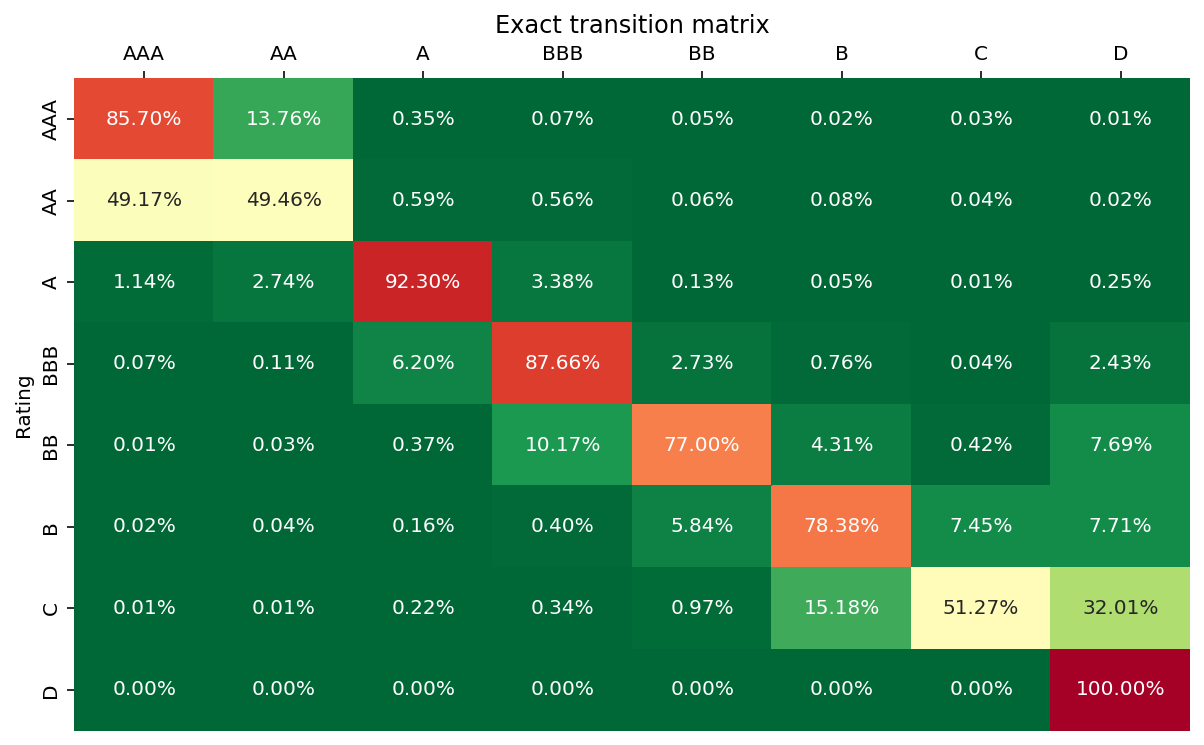

In [10]:
# Exact generator
exactMatrix  = ExactMatrix(exactGenerator)

# Show matrix
plotMatrix(exactMatrix, 'Exact transition matrix', 'Percent')